# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [2]:
# Dataset and model path
DATASET_PATH = "./datasets/Ra_128_indexed.h5"
DATASET_FAKE_PATH = "./datasets/CcGAN_SAGAN_dim_128_128_batchSizeG_64_batchSizeD_64_lrG_1e-04_lrD_1e-04_nIters_60000_nDsteps_4_soft_0.047_108.739_loss_hinge_seed_42_in_generate.h5"
MODEL_DIR = "./models"
OUTPUT_DIR = "./outputs"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
FINE_TUNING_TYPE = "full" # "partial" or "full"
NUM_EPOCHS = 400
LR = 1e-3
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 10

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Path
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR, exist_ok=True)
    print(f"Make new directory {MODEL_DIR}")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Make new directory {OUTPUT_DIR}")
MODEL_PATH = f"{MODEL_DIR}/VGG16_{FINE_TUNING_TYPE}_argumented_({".".join(os.path.basename(DATASET_FAKE_PATH).split(".")[:-1])})_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.pth"
OUTPUT_PATH = f"{OUTPUT_DIR}/VGG16_{FINE_TUNING_TYPE}_argumented_({".".join(os.path.basename(DATASET_FAKE_PATH).split(".")[:-1])})_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.csv"

Device: cuda


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
if FINE_TUNING_TYPE == "partial":
    for param in vgg16.features.parameters():
        param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/home/ubuntu/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images (`images`) and labels (`labels`).

In [4]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Load fake datasets
with h5py.File(DATASET_FAKE_PATH, "r") as f:
    images_fake = f["images"][:].astype(float)
    labels_fake = f["labels"][:].astype(float)
N_fake_all = len(images_fake)
print("Fake images and labels loaded.")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection fake
indx_fake = np.where((labels_fake >= MIN_LABEL) * (labels_fake < MAX_LABEL) == True)[0]
labels_fake = labels_fake[indx_fake]
images_fake = images_fake[indx_fake]
print(f"Select fake indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

# Fake to tensor
images_fake = torch.from_numpy(images_fake).permute(0, 3, 1, 2)
labels_fake = torch.from_numpy(labels_fake)
print("Transform `images_fake` and `labels_fake` to tensors.")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)



Fake images and labels loaded.
Fake Images Shape: (9192, 128, 128, 3)
Fake Labels Shape: (9192,)


Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)



Select fake indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Fake Images Shape: (9191, 128, 128, 3)
Fake Labels Shape: (9191,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])
Transform `images_fake` and `labels_fake` to tensors.
Fake Images Shape: torch.Size([9191, 3, 128, 128])
Fake Labels Shape: torch.Size([9191])


Then use `train_test_split` function to get data for training and validation, and add all fake images and labels to the training set.

In [5]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)

# Add fake images and labels
images_train = torch.cat((images_train, images_fake), dim=0)
labels_train = torch.cat((labels_train, labels_fake), dim=0)

Implement images standardization and labels normalization.

In [6]:
# Image standardization
mean = images_train.mean(dim=[0, 2, 3], keepdim=True)
std = images_train.std(dim=[0, 2, 3], keepdim=True)
print(f"Mean of `images_train`: {mean}")
print(f"Std of `images_train`: {std}")
images_train = (images_train - mean) / std
images_val = (images_val - mean) / std

# Label normalization
labels_train = (labels_train - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)
labels_val = (labels_val - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Mean of `images_train`: tensor([[[[ 16.6693]],

         [[ 20.2186]],

         [[102.6262]]]], dtype=torch.float64)
Std of `images_train`: tensor([[[[16.6376]],

         [[17.4753]],

         [[37.5547]]]], dtype=torch.float64)


Train test split with test size 0.2.
Images (train) Shape: torch.Size([16544, 3, 128, 128])
Images (val) Shape: torch.Size([1839, 3, 128, 128])
Labels (train) Shape: torch.Size([16544])
Labels (val) Shape: torch.Size([1839])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [7]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_18141/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([16544, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([16544, 1])
Shape of `images_val_tensor`: torch.Size([1839, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([1839, 1])


/tmp/ipykernel_18141/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
/tmp/ipykernel_18141/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_18141/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [8]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# Loop by epoch
for epoch in range(NUM_EPOCHS):

    # Train
    vgg16.train()
    train_loss = 0.0
    train_size = 0
    for batch_images, batch_labels in train_loader:
        # Load data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # Pass loss value
        outputs = vgg16(batch_images)
        loss = criterion(outputs, batch_labels)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add to the total loss
        batch_size = batch_images.size(0)
        train_loss += loss.item() * batch_size
        train_size += batch_size

    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)

    # Validate
    vgg16.eval()
    val_loss = 0
    val_samples = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Load data
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # Output
            outputs = vgg16(batch_images)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            # Add to total loss
            batch_size = batch_images.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size
    val_loss /= val_samples
    val_loss_list.append(val_loss)

    # Print
    print(
        f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
    )

    # Scheduler
    scheduler.step(val_loss)

[Epoch 1 / 400] [Train Loss 0.466874 (MSE)] [Valid Loss 0.026231 (MSE)] [Learning Rate: 0.001]


[Epoch 2 / 400] [Train Loss 0.040967 (MSE)] [Valid Loss 0.030856 (MSE)] [Learning Rate: 0.001]


[Epoch 3 / 400] [Train Loss 0.044374 (MSE)] [Valid Loss 0.014905 (MSE)] [Learning Rate: 0.001]


[Epoch 4 / 400] [Train Loss 0.036787 (MSE)] [Valid Loss 0.014382 (MSE)] [Learning Rate: 0.001]


[Epoch 5 / 400] [Train Loss 0.034468 (MSE)] [Valid Loss 0.028070 (MSE)] [Learning Rate: 0.001]


[Epoch 6 / 400] [Train Loss 0.036549 (MSE)] [Valid Loss 0.013072 (MSE)] [Learning Rate: 0.001]


[Epoch 7 / 400] [Train Loss 0.036360 (MSE)] [Valid Loss 0.030512 (MSE)] [Learning Rate: 0.001]


[Epoch 8 / 400] [Train Loss 0.033252 (MSE)] [Valid Loss 0.012964 (MSE)] [Learning Rate: 0.001]


[Epoch 9 / 400] [Train Loss 0.024749 (MSE)] [Valid Loss 0.014003 (MSE)] [Learning Rate: 0.001]


[Epoch 10 / 400] [Train Loss 0.021426 (MSE)] [Valid Loss 0.009812 (MSE)] [Learning Rate: 0.001]


[Epoch 11 / 400] [Train Loss 0.020779 (MSE)] [Valid Loss 0.009295 (MSE)] [Learning Rate: 0.001]


[Epoch 12 / 400] [Train Loss 0.020470 (MSE)] [Valid Loss 0.009732 (MSE)] [Learning Rate: 0.001]


[Epoch 13 / 400] [Train Loss 0.021078 (MSE)] [Valid Loss 0.011614 (MSE)] [Learning Rate: 0.001]


[Epoch 14 / 400] [Train Loss 0.020737 (MSE)] [Valid Loss 0.017202 (MSE)] [Learning Rate: 0.001]


[Epoch 15 / 400] [Train Loss 0.019517 (MSE)] [Valid Loss 0.009765 (MSE)] [Learning Rate: 0.001]


[Epoch 16 / 400] [Train Loss 0.017822 (MSE)] [Valid Loss 0.012752 (MSE)] [Learning Rate: 0.001]


[Epoch 17 / 400] [Train Loss 0.018311 (MSE)] [Valid Loss 0.010147 (MSE)] [Learning Rate: 0.001]


[Epoch 18 / 400] [Train Loss 0.015834 (MSE)] [Valid Loss 0.010198 (MSE)] [Learning Rate: 0.0005]


[Epoch 19 / 400] [Train Loss 0.015035 (MSE)] [Valid Loss 0.008174 (MSE)] [Learning Rate: 0.0005]


[Epoch 20 / 400] [Train Loss 0.014636 (MSE)] [Valid Loss 0.010053 (MSE)] [Learning Rate: 0.0005]


[Epoch 21 / 400] [Train Loss 0.015015 (MSE)] [Valid Loss 0.007914 (MSE)] [Learning Rate: 0.0005]


[Epoch 22 / 400] [Train Loss 0.015404 (MSE)] [Valid Loss 0.008270 (MSE)] [Learning Rate: 0.0005]


[Epoch 23 / 400] [Train Loss 0.014845 (MSE)] [Valid Loss 0.009976 (MSE)] [Learning Rate: 0.0005]


[Epoch 24 / 400] [Train Loss 0.014641 (MSE)] [Valid Loss 0.009230 (MSE)] [Learning Rate: 0.0005]


[Epoch 25 / 400] [Train Loss 0.014450 (MSE)] [Valid Loss 0.008343 (MSE)] [Learning Rate: 0.0005]


[Epoch 26 / 400] [Train Loss 0.014342 (MSE)] [Valid Loss 0.009269 (MSE)] [Learning Rate: 0.0005]


[Epoch 27 / 400] [Train Loss 0.014512 (MSE)] [Valid Loss 0.009066 (MSE)] [Learning Rate: 0.0005]


[Epoch 28 / 400] [Train Loss 0.013165 (MSE)] [Valid Loss 0.007405 (MSE)] [Learning Rate: 0.00025]


[Epoch 29 / 400] [Train Loss 0.012461 (MSE)] [Valid Loss 0.008852 (MSE)] [Learning Rate: 0.00025]


[Epoch 30 / 400] [Train Loss 0.012842 (MSE)] [Valid Loss 0.006477 (MSE)] [Learning Rate: 0.00025]


[Epoch 31 / 400] [Train Loss 0.012129 (MSE)] [Valid Loss 0.006689 (MSE)] [Learning Rate: 0.00025]


[Epoch 32 / 400] [Train Loss 0.012243 (MSE)] [Valid Loss 0.008045 (MSE)] [Learning Rate: 0.00025]


[Epoch 33 / 400] [Train Loss 0.012137 (MSE)] [Valid Loss 0.007564 (MSE)] [Learning Rate: 0.00025]


[Epoch 34 / 400] [Train Loss 0.011901 (MSE)] [Valid Loss 0.005987 (MSE)] [Learning Rate: 0.00025]


[Epoch 35 / 400] [Train Loss 0.011435 (MSE)] [Valid Loss 0.006573 (MSE)] [Learning Rate: 0.00025]


[Epoch 36 / 400] [Train Loss 0.011399 (MSE)] [Valid Loss 0.006163 (MSE)] [Learning Rate: 0.00025]


[Epoch 37 / 400] [Train Loss 0.011376 (MSE)] [Valid Loss 0.006890 (MSE)] [Learning Rate: 0.00025]


[Epoch 38 / 400] [Train Loss 0.011457 (MSE)] [Valid Loss 0.006303 (MSE)] [Learning Rate: 0.00025]


[Epoch 39 / 400] [Train Loss 0.011258 (MSE)] [Valid Loss 0.006523 (MSE)] [Learning Rate: 0.00025]


[Epoch 40 / 400] [Train Loss 0.011311 (MSE)] [Valid Loss 0.005575 (MSE)] [Learning Rate: 0.00025]


[Epoch 41 / 400] [Train Loss 0.010753 (MSE)] [Valid Loss 0.005264 (MSE)] [Learning Rate: 0.00025]


[Epoch 42 / 400] [Train Loss 0.010383 (MSE)] [Valid Loss 0.005643 (MSE)] [Learning Rate: 0.00025]


[Epoch 43 / 400] [Train Loss 0.010356 (MSE)] [Valid Loss 0.006546 (MSE)] [Learning Rate: 0.00025]


[Epoch 44 / 400] [Train Loss 0.010253 (MSE)] [Valid Loss 0.005844 (MSE)] [Learning Rate: 0.00025]


[Epoch 45 / 400] [Train Loss 0.009617 (MSE)] [Valid Loss 0.005591 (MSE)] [Learning Rate: 0.00025]


[Epoch 46 / 400] [Train Loss 0.009711 (MSE)] [Valid Loss 0.007127 (MSE)] [Learning Rate: 0.00025]


[Epoch 47 / 400] [Train Loss 0.009508 (MSE)] [Valid Loss 0.005320 (MSE)] [Learning Rate: 0.00025]


[Epoch 48 / 400] [Train Loss 0.007905 (MSE)] [Valid Loss 0.004556 (MSE)] [Learning Rate: 0.000125]


[Epoch 49 / 400] [Train Loss 0.006840 (MSE)] [Valid Loss 0.004301 (MSE)] [Learning Rate: 0.000125]


[Epoch 50 / 400] [Train Loss 0.006601 (MSE)] [Valid Loss 0.004149 (MSE)] [Learning Rate: 0.000125]


[Epoch 51 / 400] [Train Loss 0.006576 (MSE)] [Valid Loss 0.004264 (MSE)] [Learning Rate: 0.000125]


[Epoch 52 / 400] [Train Loss 0.006231 (MSE)] [Valid Loss 0.004687 (MSE)] [Learning Rate: 0.000125]


[Epoch 53 / 400] [Train Loss 0.006262 (MSE)] [Valid Loss 0.004418 (MSE)] [Learning Rate: 0.000125]


[Epoch 54 / 400] [Train Loss 0.005889 (MSE)] [Valid Loss 0.005312 (MSE)] [Learning Rate: 0.000125]


[Epoch 55 / 400] [Train Loss 0.005650 (MSE)] [Valid Loss 0.004629 (MSE)] [Learning Rate: 0.000125]


[Epoch 56 / 400] [Train Loss 0.005335 (MSE)] [Valid Loss 0.003467 (MSE)] [Learning Rate: 0.000125]


[Epoch 57 / 400] [Train Loss 0.005379 (MSE)] [Valid Loss 0.003439 (MSE)] [Learning Rate: 0.000125]


[Epoch 58 / 400] [Train Loss 0.005257 (MSE)] [Valid Loss 0.003643 (MSE)] [Learning Rate: 0.000125]


[Epoch 59 / 400] [Train Loss 0.005049 (MSE)] [Valid Loss 0.003442 (MSE)] [Learning Rate: 0.000125]


[Epoch 60 / 400] [Train Loss 0.005087 (MSE)] [Valid Loss 0.003537 (MSE)] [Learning Rate: 0.000125]


[Epoch 61 / 400] [Train Loss 0.005346 (MSE)] [Valid Loss 0.004425 (MSE)] [Learning Rate: 0.000125]


[Epoch 62 / 400] [Train Loss 0.004924 (MSE)] [Valid Loss 0.003140 (MSE)] [Learning Rate: 0.000125]


[Epoch 63 / 400] [Train Loss 0.004808 (MSE)] [Valid Loss 0.003709 (MSE)] [Learning Rate: 0.000125]


[Epoch 64 / 400] [Train Loss 0.004524 (MSE)] [Valid Loss 0.003319 (MSE)] [Learning Rate: 0.000125]


[Epoch 65 / 400] [Train Loss 0.004601 (MSE)] [Valid Loss 0.003712 (MSE)] [Learning Rate: 0.000125]


[Epoch 66 / 400] [Train Loss 0.004365 (MSE)] [Valid Loss 0.003465 (MSE)] [Learning Rate: 0.000125]


[Epoch 67 / 400] [Train Loss 0.004397 (MSE)] [Valid Loss 0.004004 (MSE)] [Learning Rate: 0.000125]


[Epoch 68 / 400] [Train Loss 0.004541 (MSE)] [Valid Loss 0.003430 (MSE)] [Learning Rate: 0.000125]


[Epoch 69 / 400] [Train Loss 0.003714 (MSE)] [Valid Loss 0.002495 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 70 / 400] [Train Loss 0.003336 (MSE)] [Valid Loss 0.002505 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 71 / 400] [Train Loss 0.003182 (MSE)] [Valid Loss 0.002561 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 72 / 400] [Train Loss 0.003317 (MSE)] [Valid Loss 0.002670 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 73 / 400] [Train Loss 0.003135 (MSE)] [Valid Loss 0.002781 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 74 / 400] [Train Loss 0.003006 (MSE)] [Valid Loss 0.002322 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 75 / 400] [Train Loss 0.003020 (MSE)] [Valid Loss 0.002653 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 76 / 400] [Train Loss 0.003068 (MSE)] [Valid Loss 0.002742 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 77 / 400] [Train Loss 0.002889 (MSE)] [Valid Loss 0.002493 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 78 / 400] [Train Loss 0.003029 (MSE)] [Valid Loss 0.002680 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 79 / 400] [Train Loss 0.002991 (MSE)] [Valid Loss 0.002639 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 80 / 400] [Train Loss 0.003027 (MSE)] [Valid Loss 0.002321 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 81 / 400] [Train Loss 0.003004 (MSE)] [Valid Loss 0.002108 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 82 / 400] [Train Loss 0.002751 (MSE)] [Valid Loss 0.002971 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 83 / 400] [Train Loss 0.002753 (MSE)] [Valid Loss 0.002215 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 84 / 400] [Train Loss 0.002811 (MSE)] [Valid Loss 0.002325 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 85 / 400] [Train Loss 0.002847 (MSE)] [Valid Loss 0.002253 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 86 / 400] [Train Loss 0.002763 (MSE)] [Valid Loss 0.002233 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 87 / 400] [Train Loss 0.002706 (MSE)] [Valid Loss 0.002173 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 88 / 400] [Train Loss 0.002257 (MSE)] [Valid Loss 0.001957 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 89 / 400] [Train Loss 0.002153 (MSE)] [Valid Loss 0.002110 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 90 / 400] [Train Loss 0.002196 (MSE)] [Valid Loss 0.002088 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 91 / 400] [Train Loss 0.002102 (MSE)] [Valid Loss 0.002052 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 92 / 400] [Train Loss 0.002043 (MSE)] [Valid Loss 0.002380 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 93 / 400] [Train Loss 0.002129 (MSE)] [Valid Loss 0.001959 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 94 / 400] [Train Loss 0.002122 (MSE)] [Valid Loss 0.002148 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 95 / 400] [Train Loss 0.001879 (MSE)] [Valid Loss 0.001922 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 96 / 400] [Train Loss 0.001821 (MSE)] [Valid Loss 0.001893 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 97 / 400] [Train Loss 0.001805 (MSE)] [Valid Loss 0.001876 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 98 / 400] [Train Loss 0.001744 (MSE)] [Valid Loss 0.001864 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 99 / 400] [Train Loss 0.001768 (MSE)] [Valid Loss 0.001791 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 100 / 400] [Train Loss 0.001727 (MSE)] [Valid Loss 0.001866 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 101 / 400] [Train Loss 0.001734 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 102 / 400] [Train Loss 0.001733 (MSE)] [Valid Loss 0.001891 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 103 / 400] [Train Loss 0.001706 (MSE)] [Valid Loss 0.001925 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 104 / 400] [Train Loss 0.001668 (MSE)] [Valid Loss 0.001971 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 105 / 400] [Train Loss 0.001635 (MSE)] [Valid Loss 0.001999 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 106 / 400] [Train Loss 0.001546 (MSE)] [Valid Loss 0.001848 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 107 / 400] [Train Loss 0.001503 (MSE)] [Valid Loss 0.001781 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 108 / 400] [Train Loss 0.001523 (MSE)] [Valid Loss 0.001747 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 109 / 400] [Train Loss 0.001535 (MSE)] [Valid Loss 0.001932 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 110 / 400] [Train Loss 0.001472 (MSE)] [Valid Loss 0.001708 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 111 / 400] [Train Loss 0.001494 (MSE)] [Valid Loss 0.001869 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 112 / 400] [Train Loss 0.001465 (MSE)] [Valid Loss 0.001968 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 113 / 400] [Train Loss 0.001465 (MSE)] [Valid Loss 0.001881 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 114 / 400] [Train Loss 0.001442 (MSE)] [Valid Loss 0.001799 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 115 / 400] [Train Loss 0.001473 (MSE)] [Valid Loss 0.001855 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 116 / 400] [Train Loss 0.001469 (MSE)] [Valid Loss 0.001836 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 117 / 400] [Train Loss 0.001407 (MSE)] [Valid Loss 0.001907 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 118 / 400] [Train Loss 0.001418 (MSE)] [Valid Loss 0.001793 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 119 / 400] [Train Loss 0.001360 (MSE)] [Valid Loss 0.001782 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 120 / 400] [Train Loss 0.001366 (MSE)] [Valid Loss 0.001913 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 121 / 400] [Train Loss 0.001336 (MSE)] [Valid Loss 0.001790 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 122 / 400] [Train Loss 0.001324 (MSE)] [Valid Loss 0.001742 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 123 / 400] [Train Loss 0.001325 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 124 / 400] [Train Loss 0.001317 (MSE)] [Valid Loss 0.001868 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 125 / 400] [Train Loss 0.001316 (MSE)] [Valid Loss 0.001853 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 126 / 400] [Train Loss 0.001271 (MSE)] [Valid Loss 0.001785 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 127 / 400] [Train Loss 0.001299 (MSE)] [Valid Loss 0.001869 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 128 / 400] [Train Loss 0.001292 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 129 / 400] [Train Loss 0.001274 (MSE)] [Valid Loss 0.001824 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 130 / 400] [Train Loss 0.001299 (MSE)] [Valid Loss 0.001817 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 131 / 400] [Train Loss 0.001291 (MSE)] [Valid Loss 0.001778 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 132 / 400] [Train Loss 0.001269 (MSE)] [Valid Loss 0.001825 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 133 / 400] [Train Loss 0.001258 (MSE)] [Valid Loss 0.001851 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 134 / 400] [Train Loss 0.001244 (MSE)] [Valid Loss 0.001785 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 135 / 400] [Train Loss 0.001276 (MSE)] [Valid Loss 0.001817 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 136 / 400] [Train Loss 0.001251 (MSE)] [Valid Loss 0.001806 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 137 / 400] [Train Loss 0.001267 (MSE)] [Valid Loss 0.001832 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 138 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 139 / 400] [Train Loss 0.001253 (MSE)] [Valid Loss 0.001819 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 140 / 400] [Train Loss 0.001237 (MSE)] [Valid Loss 0.001835 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 141 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001823 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 142 / 400] [Train Loss 0.001248 (MSE)] [Valid Loss 0.001817 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 143 / 400] [Train Loss 0.001240 (MSE)] [Valid Loss 0.001805 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 144 / 400] [Train Loss 0.001257 (MSE)] [Valid Loss 0.001824 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 145 / 400] [Train Loss 0.001238 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 146 / 400] [Train Loss 0.001247 (MSE)] [Valid Loss 0.001823 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 147 / 400] [Train Loss 0.001255 (MSE)] [Valid Loss 0.001821 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 148 / 400] [Train Loss 0.001251 (MSE)] [Valid Loss 0.001822 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 149 / 400] [Train Loss 0.001247 (MSE)] [Valid Loss 0.001822 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 150 / 400] [Train Loss 0.001249 (MSE)] [Valid Loss 0.001821 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 151 / 400] [Train Loss 0.001254 (MSE)] [Valid Loss 0.001824 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 152 / 400] [Train Loss 0.001249 (MSE)] [Valid Loss 0.001822 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 153 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001821 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 154 / 400] [Train Loss 0.001209 (MSE)] [Valid Loss 0.001824 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 155 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001821 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 156 / 400] [Train Loss 0.001205 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 157 / 400] [Train Loss 0.001238 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 158 / 400] [Train Loss 0.001240 (MSE)] [Valid Loss 0.001818 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 159 / 400] [Train Loss 0.001254 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 160 / 400] [Train Loss 0.001220 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 161 / 400] [Train Loss 0.001233 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 162 / 400] [Train Loss 0.001250 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 163 / 400] [Train Loss 0.001215 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 164 / 400] [Train Loss 0.001261 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 165 / 400] [Train Loss 0.001242 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 166 / 400] [Train Loss 0.001216 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 167 / 400] [Train Loss 0.001255 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 168 / 400] [Train Loss 0.001222 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 169 / 400] [Train Loss 0.001246 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 170 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 171 / 400] [Train Loss 0.001249 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 172 / 400] [Train Loss 0.001252 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 173 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 174 / 400] [Train Loss 0.001194 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 175 / 400] [Train Loss 0.001243 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 176 / 400] [Train Loss 0.001220 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 177 / 400] [Train Loss 0.001249 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 178 / 400] [Train Loss 0.001249 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 179 / 400] [Train Loss 0.001235 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 180 / 400] [Train Loss 0.001257 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 181 / 400] [Train Loss 0.001237 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 182 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 183 / 400] [Train Loss 0.001222 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 184 / 400] [Train Loss 0.001244 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 185 / 400] [Train Loss 0.001219 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 186 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 187 / 400] [Train Loss 0.001253 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 188 / 400] [Train Loss 0.001259 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 189 / 400] [Train Loss 0.001231 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 190 / 400] [Train Loss 0.001189 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 191 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 192 / 400] [Train Loss 0.001238 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 193 / 400] [Train Loss 0.001243 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 194 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 195 / 400] [Train Loss 0.001264 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 196 / 400] [Train Loss 0.001231 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 197 / 400] [Train Loss 0.001253 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 198 / 400] [Train Loss 0.001223 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 199 / 400] [Train Loss 0.001206 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 200 / 400] [Train Loss 0.001225 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 201 / 400] [Train Loss 0.001243 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 202 / 400] [Train Loss 0.001245 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 203 / 400] [Train Loss 0.001209 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 204 / 400] [Train Loss 0.001219 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 205 / 400] [Train Loss 0.001242 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 206 / 400] [Train Loss 0.001190 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 207 / 400] [Train Loss 0.001245 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 208 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001817 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 209 / 400] [Train Loss 0.001226 (MSE)] [Valid Loss 0.001817 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 210 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 211 / 400] [Train Loss 0.001234 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 212 / 400] [Train Loss 0.001217 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 213 / 400] [Train Loss 0.001243 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 214 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 215 / 400] [Train Loss 0.001267 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 216 / 400] [Train Loss 0.001247 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 217 / 400] [Train Loss 0.001222 (MSE)] [Valid Loss 0.001817 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 218 / 400] [Train Loss 0.001279 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 219 / 400] [Train Loss 0.001242 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 220 / 400] [Train Loss 0.001215 (MSE)] [Valid Loss 0.001818 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 221 / 400] [Train Loss 0.001231 (MSE)] [Valid Loss 0.001818 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 222 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 223 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 224 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 225 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 226 / 400] [Train Loss 0.001228 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 227 / 400] [Train Loss 0.001220 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 228 / 400] [Train Loss 0.001243 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 229 / 400] [Train Loss 0.001201 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 230 / 400] [Train Loss 0.001245 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 231 / 400] [Train Loss 0.001240 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 232 / 400] [Train Loss 0.001243 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 233 / 400] [Train Loss 0.001233 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 234 / 400] [Train Loss 0.001237 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 235 / 400] [Train Loss 0.001217 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 236 / 400] [Train Loss 0.001226 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 237 / 400] [Train Loss 0.001258 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 238 / 400] [Train Loss 0.001231 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 239 / 400] [Train Loss 0.001243 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 240 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 241 / 400] [Train Loss 0.001234 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 242 / 400] [Train Loss 0.001261 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 243 / 400] [Train Loss 0.001223 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 244 / 400] [Train Loss 0.001202 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 245 / 400] [Train Loss 0.001244 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 246 / 400] [Train Loss 0.001221 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 247 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 248 / 400] [Train Loss 0.001212 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 249 / 400] [Train Loss 0.001263 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 250 / 400] [Train Loss 0.001207 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 251 / 400] [Train Loss 0.001221 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 252 / 400] [Train Loss 0.001228 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 253 / 400] [Train Loss 0.001227 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 254 / 400] [Train Loss 0.001204 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 255 / 400] [Train Loss 0.001255 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 256 / 400] [Train Loss 0.001225 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 257 / 400] [Train Loss 0.001259 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 258 / 400] [Train Loss 0.001202 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 259 / 400] [Train Loss 0.001234 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 260 / 400] [Train Loss 0.001255 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 261 / 400] [Train Loss 0.001217 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 262 / 400] [Train Loss 0.001214 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 263 / 400] [Train Loss 0.001226 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 264 / 400] [Train Loss 0.001274 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 265 / 400] [Train Loss 0.001215 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 266 / 400] [Train Loss 0.001247 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 267 / 400] [Train Loss 0.001268 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 268 / 400] [Train Loss 0.001204 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 269 / 400] [Train Loss 0.001216 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 270 / 400] [Train Loss 0.001234 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 271 / 400] [Train Loss 0.001249 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 272 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 273 / 400] [Train Loss 0.001237 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 274 / 400] [Train Loss 0.001217 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 275 / 400] [Train Loss 0.001209 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 276 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 277 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 278 / 400] [Train Loss 0.001204 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 279 / 400] [Train Loss 0.001237 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 280 / 400] [Train Loss 0.001271 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 281 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 282 / 400] [Train Loss 0.001237 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 283 / 400] [Train Loss 0.001256 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 284 / 400] [Train Loss 0.001213 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 285 / 400] [Train Loss 0.001220 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 286 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 287 / 400] [Train Loss 0.001268 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 288 / 400] [Train Loss 0.001219 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 289 / 400] [Train Loss 0.001216 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 290 / 400] [Train Loss 0.001226 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 291 / 400] [Train Loss 0.001222 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 292 / 400] [Train Loss 0.001223 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 293 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 294 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 295 / 400] [Train Loss 0.001215 (MSE)] [Valid Loss 0.001806 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 296 / 400] [Train Loss 0.001242 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 297 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 298 / 400] [Train Loss 0.001227 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 299 / 400] [Train Loss 0.001246 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 300 / 400] [Train Loss 0.001218 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 301 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 302 / 400] [Train Loss 0.001221 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 303 / 400] [Train Loss 0.001246 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 304 / 400] [Train Loss 0.001208 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 305 / 400] [Train Loss 0.001251 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 306 / 400] [Train Loss 0.001231 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 307 / 400] [Train Loss 0.001255 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 308 / 400] [Train Loss 0.001244 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 309 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 310 / 400] [Train Loss 0.001228 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 311 / 400] [Train Loss 0.001244 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 312 / 400] [Train Loss 0.001214 (MSE)] [Valid Loss 0.001806 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 313 / 400] [Train Loss 0.001235 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 314 / 400] [Train Loss 0.001238 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 315 / 400] [Train Loss 0.001233 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 316 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 317 / 400] [Train Loss 0.001217 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 318 / 400] [Train Loss 0.001242 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 319 / 400] [Train Loss 0.001258 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 320 / 400] [Train Loss 0.001261 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 321 / 400] [Train Loss 0.001233 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 322 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 323 / 400] [Train Loss 0.001253 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 324 / 400] [Train Loss 0.001272 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 325 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 326 / 400] [Train Loss 0.001239 (MSE)] [Valid Loss 0.001816 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 327 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 328 / 400] [Train Loss 0.001266 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 329 / 400] [Train Loss 0.001245 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 330 / 400] [Train Loss 0.001232 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 331 / 400] [Train Loss 0.001234 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 332 / 400] [Train Loss 0.001244 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 333 / 400] [Train Loss 0.001222 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 334 / 400] [Train Loss 0.001235 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 335 / 400] [Train Loss 0.001241 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 336 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 337 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 338 / 400] [Train Loss 0.001215 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 339 / 400] [Train Loss 0.001226 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 340 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001817 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 341 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 342 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 343 / 400] [Train Loss 0.001255 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 344 / 400] [Train Loss 0.001188 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 345 / 400] [Train Loss 0.001204 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 346 / 400] [Train Loss 0.001245 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 347 / 400] [Train Loss 0.001235 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 348 / 400] [Train Loss 0.001254 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 349 / 400] [Train Loss 0.001209 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 350 / 400] [Train Loss 0.001216 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 351 / 400] [Train Loss 0.001213 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 352 / 400] [Train Loss 0.001209 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 353 / 400] [Train Loss 0.001238 (MSE)] [Valid Loss 0.001815 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 354 / 400] [Train Loss 0.001203 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 355 / 400] [Train Loss 0.001238 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 356 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 357 / 400] [Train Loss 0.001220 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 358 / 400] [Train Loss 0.001212 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 359 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 360 / 400] [Train Loss 0.001198 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 361 / 400] [Train Loss 0.001208 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 362 / 400] [Train Loss 0.001247 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 363 / 400] [Train Loss 0.001201 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 364 / 400] [Train Loss 0.001234 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 365 / 400] [Train Loss 0.001219 (MSE)] [Valid Loss 0.001806 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 366 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 367 / 400] [Train Loss 0.001246 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 368 / 400] [Train Loss 0.001259 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 369 / 400] [Train Loss 0.001215 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 370 / 400] [Train Loss 0.001240 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 371 / 400] [Train Loss 0.001213 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 372 / 400] [Train Loss 0.001235 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 373 / 400] [Train Loss 0.001210 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 374 / 400] [Train Loss 0.001235 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 375 / 400] [Train Loss 0.001253 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 376 / 400] [Train Loss 0.001250 (MSE)] [Valid Loss 0.001813 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 377 / 400] [Train Loss 0.001223 (MSE)] [Valid Loss 0.001814 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 378 / 400] [Train Loss 0.001251 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 379 / 400] [Train Loss 0.001225 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 380 / 400] [Train Loss 0.001240 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 381 / 400] [Train Loss 0.001242 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 382 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 383 / 400] [Train Loss 0.001216 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 384 / 400] [Train Loss 0.001264 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 385 / 400] [Train Loss 0.001236 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 386 / 400] [Train Loss 0.001223 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 387 / 400] [Train Loss 0.001220 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 388 / 400] [Train Loss 0.001206 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 389 / 400] [Train Loss 0.001227 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 390 / 400] [Train Loss 0.001192 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 391 / 400] [Train Loss 0.001242 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 392 / 400] [Train Loss 0.001229 (MSE)] [Valid Loss 0.001812 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 393 / 400] [Train Loss 0.001221 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 394 / 400] [Train Loss 0.001253 (MSE)] [Valid Loss 0.001811 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 395 / 400] [Train Loss 0.001224 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 396 / 400] [Train Loss 0.001215 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 397 / 400] [Train Loss 0.001217 (MSE)] [Valid Loss 0.001807 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 398 / 400] [Train Loss 0.001230 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 399 / 400] [Train Loss 0.001204 (MSE)] [Valid Loss 0.001808 (MSE)] [Learning Rate: 1.52587890625e-08]


[Epoch 400 / 400] [Train Loss 0.001222 (MSE)] [Valid Loss 0.001809 (MSE)] [Learning Rate: 1.52587890625e-08]


Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

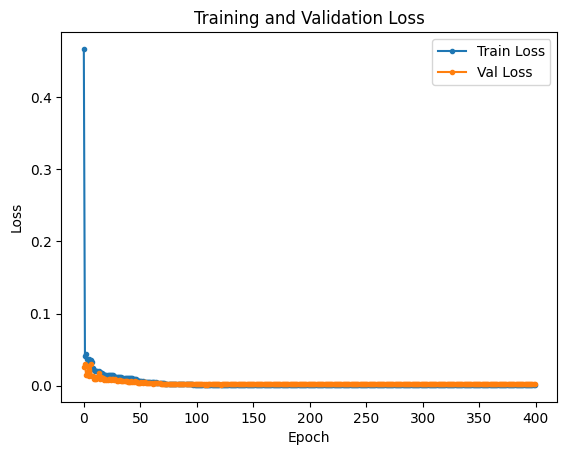

In [9]:
x = list(range(NUM_EPOCHS))
plt.plot(x, train_loss_list, label="Train Loss", marker=".")
plt.plot(x, val_loss_list, label="Val Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [10]:
# Save the trained model to disk
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ./models/VGG16_full_argumented_(CcGAN_SAGAN_dim_128_128_batchSizeG_64_batchSizeD_64_lrG_1e-04_lrD_1e-04_nIters_60000_nDsteps_4_soft_0.047_108.739_loss_hinge_seed_42_in_generate)_test_size_0.2_epoch_400_batch_size_128_lr_1e-03_seed_42.pth


To read the saved data, we can run the following codes:

In [11]:
# # Load the trained model weights
# vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# vgg16.eval()
# print("Model loaded from", MODEL_PATH)

## Exceptional test

Let's see if the model works well.

Model loaded from ./models/VGG16_full_argumented_(CcGAN_SAGAN_dim_128_128_batchSizeG_64_batchSizeD_64_lrG_1e-04_lrD_1e-04_nIters_60000_nDsteps_4_soft_0.047_108.739_loss_hinge_seed_42_in_generate)_test_size_0.2_epoch_400_batch_size_128_lr_1e-03_seed_42.pth


      Real Labels  Predicted Labels      Diff      MAPE
0           1.746          1.789602  0.043602  0.975027
1           2.695          2.738644  0.043644  0.983806
2           1.816          2.093723  0.277723  0.847069
3           2.354          2.354670  0.000670  0.999716
4           3.901          3.902497  0.001497  0.999616
...           ...               ...       ...       ...
1834        2.051          2.218632  0.167632  0.918268
1835        1.757          1.645667 -0.111333  0.936635
1836        2.593          3.033435  0.440435  0.830145
1837        4.092          3.952748 -0.139252  0.965970
1838        2.040          1.983537 -0.056463  0.972322

[1839 rows x 4 columns]
MAPE: 0.9564732039435878


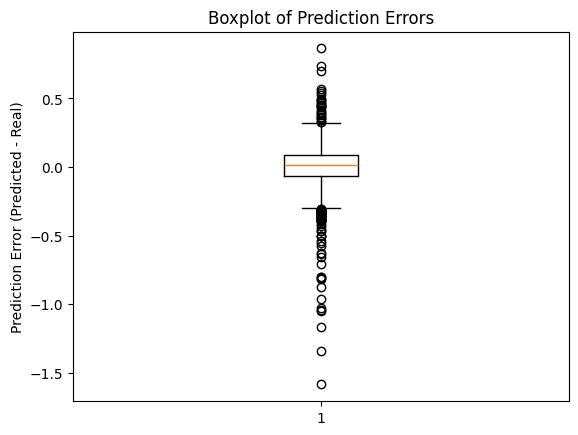

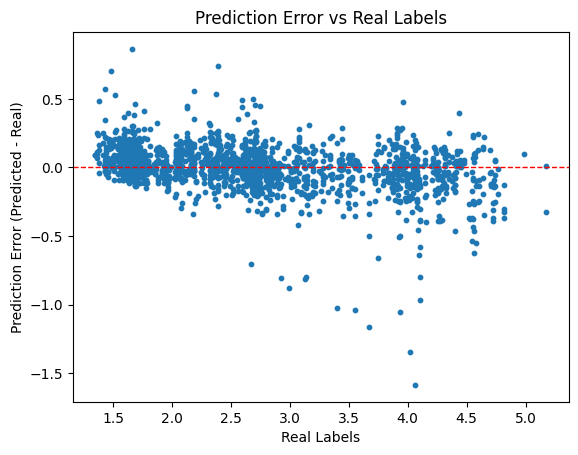

In [12]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = []
for _images_val_tensor, _labels_val_tensor in val_loader:
    preds = vgg16(_images_val_tensor.to(device)).cpu().detach().numpy()
    labels_val_predicted.append(preds)
labels_val_predicted = np.concatenate(labels_val_predicted, axis=0)

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()